In [1]:
# merge all training and testing file in|to one file respectively
#!for split in train test; do for sentiment in pos neg; do for file in aclImdb/$split/$sentiment/*; do cat $file >> aclImdb/movie_data/full_${split}_$sentiment.txt; echo >> aclImdb/movie_data/full_${split}_$sentiment.txt; done; done; done;

In [22]:
!head -10 ./aclImdb/movie_data/full_train_pos.txt

Bromwell High is a cartoon comedy. It ran at the same time as some other programs about school life, such as "Teachers". My 35 years in the teaching profession lead me to believe that Bromwell High's satire is much closer to reality than is "Teachers". The scramble to survive financially, the insightful students who can see right through their pathetic teachers' pomp, the pettiness of the whole situation, all remind me of the schools I knew and their students. When I saw the episode in which a student repeatedly tried to burn down the school, I immediately recalled ......... at .......... High. A classic line: INSPECTOR: I'm here to sack one of your teachers. STUDENT: Welcome to Bromwell High. I expect that many adults of my age think that Bromwell High is far fetched. What a pity that it isn't!
Homelessness (or Houselessness as George Carlin stated) has been an issue for years but never a plan to help those on the street that were once considered human who did everything from going to

In [3]:
#build train_data_tokens.p, all_train_tokens.p, val_data_tokens.p, test_data_tokens.p
#!python load_data.py   

In [1]:
import numpy as np
import torch
import pickle as pkl
import torch.nn.functional as F
import matplotlib.pyplot as plt

from bagofwords import BagOfWords
from module import Module as M
from hyperparameter import Hyperparameter as hp
import RR

%load_ext autoreload
%autoreload 2


prepath_data = hp.prepath_data


In [21]:
#Hyperparameter tuning
if_rp = 0 #whether to replace punctuations with space
if_rb = 0 #whether to replace line break with space
if_l = 1 #whether to lowercase the line
if_rs = 0 #whether to remove stopwords
max_vocab_size = 10000
emb_dim = 200

learning_rate = 0.001
wd = 1e-5 #weight decay
num_epochs = 20 # number epoch to train
lr0 = 0.05
lrd = 0.8
mi = 1
ma = 2

In [15]:
train_data, train_targets, val_data, val_targets, test_data, test_targets = RR.load_raw_data(if_rp = if_rp, if_rb = if_rb, if_l = if_l, if_rs = if_rs)
RR.tokenization(train_data,val_data,test_data, min = mi, max = ma)
train_data_tokens, val_data_tokens, test_data_tokens, all_train_tokens = RR.load_tokens()


Train dataset size is 20000
Val dataset size is 5000
Test dataset size is 25000
Tokenizing val data
Tokenizing test data
Tokenizing train data
Tokenization complete
Train dataset size is 20000
Val dataset size is 5000
Test dataset size is 25000
Total number of tokens in train dataset is 4670600
Token loaded


In [16]:
#create the vocabulary of most common 10,000 tokens in the training set.
token2id, id2token = M.build_vocab(all_train_tokens, max_vocab_size)
# convert token to id in the dataset
train_data_indices = M.token2index_dataset(train_data_tokens, token2id)
val_data_indices = M.token2index_dataset(val_data_tokens, token2id)
test_data_indices = M.token2index_dataset(test_data_tokens, token2id)
# double checking
print ("Train dataset size is {}".format(len(train_data_indices)))
print ("Val dataset size is {}".format(len(val_data_indices)))
print ("Test dataset size is {}".format(len(test_data_indices)))

#create PyTorch DataLoader 
train_loader, val_loader, test_loader = RR.dataloader(train_data_indices, train_targets, val_data_indices, val_targets, test_data_indices, test_targets)

Train dataset size is 20000
Val dataset size is 5000
Test dataset size is 25000


In [17]:
def test_model(loader, model):
    """
    Help function that tests the model's performance on a dataset
    @param: loader - data loader for the dataset to test against
    """
    correct = 0
    total = 0
    model.eval()
    for data, lengths, labels in loader:
        data_batch, length_batch, label_batch = data, lengths, labels
        outputs = F.softmax(model(data_batch, length_batch), dim=1)
        predicted = outputs.max(1, keepdim=True)[1]
        
        total += labels.size(0)
        correct += predicted.eq(labels.view_as(predicted)).sum().item()
    return (100 * correct / total)


def adjust_learning_rate(optimizer, epoch, lr0, lrd):
    """Sets the learning rate to the initial LR decayed by 10 every 30 epochs"""
    lr = lr0/(1+ lrd*epoch)
    for param_group in optimizer.param_groups:
        param_group['lr'] = lr

Here we will define Bag-of-Words model in PyTorch

In [22]:
for lr0 in [0.1, 0.05, 0.02]:
    for lrd in [0.5, 0.8, 1.2, 1.5]:
        # Function for testing themodel
        model = BagOfWords(len(id2token), emb_dim)
        # Criterion and Optimizer
        criterion = torch.nn.CrossEntropyLoss()  
        optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=wd)
        #optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
        losses = []
        val_accs = []
        for epoch in range(num_epochs):
            adjust_learning_rate(optimizer, epoch, lr0, lrd)
            loss_sum = 0
            for i, (data, lengths, labels) in enumerate(train_loader):
                model.train()
                data_batch, length_batch, label_batch = data, lengths, labels
                optimizer.zero_grad()
                outputs = model(data_batch, length_batch)
                loss = criterion(outputs, label_batch)
                loss_sum += loss
                loss.backward()
                optimizer.step()
                #validate every 100 iterations
                if i > 0 and i % 600 == 0:
                    # validate
                    val_acc = test_model(val_loader, model)
                    print('Epoch: [{}/{}], Step: [{}/{}], Validation Acc: {}'.format( 
                               epoch+1, num_epochs, i+1, len(train_loader), val_acc))
            val_accs.append(val_acc)
            losses.append(loss_sum)
        val_acc = test_model(val_loader, model)
        print('hyperparameter: {}, Validation Acc: {}'.format((lr0, lrd), val_acc))
# plt.plot(losses)
# plt.show()
# plt.plot(val_accs)
# plt.show()

Epoch: [1/20], Step: [601/625], Validation Acc: 75.62
Epoch: [2/20], Step: [601/625], Validation Acc: 68.0
Epoch: [3/20], Step: [601/625], Validation Acc: 59.04
Epoch: [4/20], Step: [601/625], Validation Acc: 81.82
Epoch: [5/20], Step: [601/625], Validation Acc: 87.34
Epoch: [6/20], Step: [601/625], Validation Acc: 85.02
Epoch: [7/20], Step: [601/625], Validation Acc: 85.46
Epoch: [8/20], Step: [601/625], Validation Acc: 86.96
Epoch: [9/20], Step: [601/625], Validation Acc: 77.5
Epoch: [10/20], Step: [601/625], Validation Acc: 79.34
Epoch: [11/20], Step: [601/625], Validation Acc: 72.88
Epoch: [12/20], Step: [601/625], Validation Acc: 78.76
Epoch: [13/20], Step: [601/625], Validation Acc: 83.32
Epoch: [14/20], Step: [601/625], Validation Acc: 75.32
Epoch: [15/20], Step: [601/625], Validation Acc: 81.22
Epoch: [16/20], Step: [601/625], Validation Acc: 79.36
Epoch: [17/20], Step: [601/625], Validation Acc: 83.44
Epoch: [18/20], Step: [601/625], Validation Acc: 83.02
Epoch: [19/20], Step:

Epoch: [6/20], Step: [601/625], Validation Acc: 83.08
Epoch: [7/20], Step: [601/625], Validation Acc: 81.16
Epoch: [8/20], Step: [601/625], Validation Acc: 82.22
Epoch: [9/20], Step: [601/625], Validation Acc: 80.96
Epoch: [10/20], Step: [601/625], Validation Acc: 82.02
Epoch: [11/20], Step: [601/625], Validation Acc: 80.86
Epoch: [12/20], Step: [601/625], Validation Acc: 80.42
Epoch: [13/20], Step: [601/625], Validation Acc: 80.04
Epoch: [14/20], Step: [601/625], Validation Acc: 78.36
Epoch: [15/20], Step: [601/625], Validation Acc: 80.92
Epoch: [16/20], Step: [601/625], Validation Acc: 81.6
Epoch: [17/20], Step: [601/625], Validation Acc: 82.02
Epoch: [18/20], Step: [601/625], Validation Acc: 81.42
Epoch: [19/20], Step: [601/625], Validation Acc: 81.64
Epoch: [20/20], Step: [601/625], Validation Acc: 81.04
hyperparameter: (0.05, 1.5), Validation Acc: 80.74
Epoch: [1/20], Step: [601/625], Validation Acc: 74.88
Epoch: [2/20], Step: [601/625], Validation Acc: 75.4
Epoch: [3/20], Step: [

In [23]:
#Hyperparameter for best model
if_rp = 0 #whether to replace punctuations with space
if_rb = 0 #whether to replace line break with space
if_l = 1 #whether to lowercase the line
if_rs = 0 #whether to remove stopwords
max_vocab_size = 10000
emb_dim = 200

learning_rate = 0.02
wd = 1e-5 #weight decay
num_epochs = 20 # number epoch to train
lr0 = 0.02
lrd = 1.2
mi = 1
ma = 2

In [24]:
model = BagOfWords(len(id2token), emb_dim)
# Criterion and Optimizer
criterion = torch.nn.CrossEntropyLoss()  
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=wd)
#optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
losses = []
val_accs = []
for epoch in range(num_epochs):
    adjust_learning_rate(optimizer, epoch, lr0, lrd)
    loss_sum = 0
    for i, (data, lengths, labels) in enumerate(train_loader):
        model.train()
        data_batch, length_batch, label_batch = data, lengths, labels
        optimizer.zero_grad()
        outputs = model(data_batch, length_batch)
        loss = criterion(outputs, label_batch)
        loss_sum += loss
        loss.backward()
        optimizer.step()
        #validate every 100 iterations
        if i > 0 and i % 600 == 0:
            # validate
            val_acc = test_model(val_loader, model)
            print('Epoch: [{}/{}], Step: [{}/{}], Validation Acc: {}'.format( 
                       epoch+1, num_epochs, i+1, len(train_loader), val_acc))
    val_accs.append(val_acc)
    losses.append(loss_sum)
val_acc = test_model(val_loader, model)
print('hyperparameter: {}, Validation Acc: {}'.format((lr0, lrd), val_acc))


Epoch: [1/20], Step: [601/625], Validation Acc: 65.64
Epoch: [2/20], Step: [601/625], Validation Acc: 74.68
Epoch: [3/20], Step: [601/625], Validation Acc: 83.06
Epoch: [4/20], Step: [601/625], Validation Acc: 78.7
Epoch: [5/20], Step: [601/625], Validation Acc: 79.46
Epoch: [6/20], Step: [601/625], Validation Acc: 81.68
Epoch: [7/20], Step: [601/625], Validation Acc: 81.26
Epoch: [8/20], Step: [601/625], Validation Acc: 78.36
Epoch: [9/20], Step: [601/625], Validation Acc: 80.28
Epoch: [10/20], Step: [601/625], Validation Acc: 81.1
Epoch: [11/20], Step: [601/625], Validation Acc: 82.12
Epoch: [12/20], Step: [601/625], Validation Acc: 80.22
Epoch: [13/20], Step: [601/625], Validation Acc: 81.98
Epoch: [14/20], Step: [601/625], Validation Acc: 83.26
Epoch: [15/20], Step: [601/625], Validation Acc: 81.1
Epoch: [16/20], Step: [601/625], Validation Acc: 82.0
Epoch: [17/20], Step: [601/625], Validation Acc: 81.66
Epoch: [18/20], Step: [601/625], Validation Acc: 81.04
Epoch: [19/20], Step: [

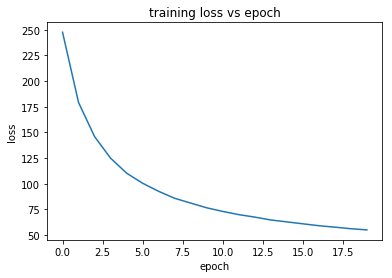

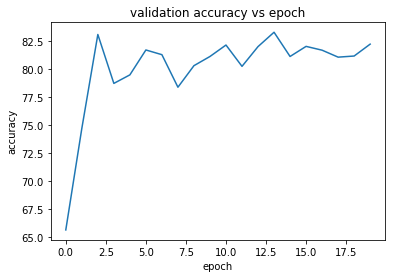

In [25]:
plt.plot(losses)
plt.xlabel('epoch')
plt.ylabel('loss')
plt.title('training loss vs epoch')
plt.show()
plt.plot(val_accs)
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.title('validation accuracy vs epoch')
plt.show()

In [26]:
print ("After training for {} epochs".format(num_epochs))
print ("Val Acc {}".format(test_model(val_loader, model)))
print ("Test Acc {}".format(test_model(test_loader, model)))

After training for 20 epochs
Val Acc 82.72
Test Acc 85.396


In [52]:

correct = 0
total = 0
model.eval()
count_right, count_wrong = 0,0
rights = []
wrongs = []
for data, lengths, labels in val_loader:
    data_batch, length_batch, label_batch = data, lengths, labels
    outputs = F.softmax(model(data_batch, length_batch), dim=1)
    predicted = outputs.max(1, keepdim=True)[1]
    i = 0
    while count_right < 3 or count_wrong<3:
        pred = predicted[i]
        true = labels[i]
        if pred == true:
            if count_right<3:
                rights.append(data_batch[i,:].data.numpy())
                count_right += 1
        else:
            wrongs.append(data_batch[i,:].data.numpy())
            count_wrong += 1
        i += 1
    break


In [57]:
output = []
for ele in rights:
        for index in ele:
            output.append(id2token[index])
(' ').join(output)

"let's be honest shall <unk> al gore no more truly cares about the environment than most folks care about <unk> foot <unk> it's a <unk> make no mistake, al gore is a <unk> three years ago he was <unk> in his home state doing 70 <unk> in a <unk> <unk> zone driving not a <unk> a <unk> or even a <unk> <unk> but a lincoln <unk> <unk> it if you <unk> or how about the fact that mr. gore & his hollywood buddies continue to use a private <unk> <unk> to attend the <unk> of <unk> <unk> <unk> so much for <unk> <unk> <unk> anyway, it takes a mere minute to <unk> look at <unk> <unk> <unk> & discover the main fundamental <unk> while the film <unk> out many seemingly impressive scientists to tell the audience the effects of supposed <unk> <unk> there is not one scientist to tell us the supposed cause of it. for example: i can take a hundred folks out to a parking lot & they can point out an <unk> which is not running right. but can they tell you with any degree of <unk> why? generally <unk> a second 

In [58]:
output = []
for ele in wrongs:
        for index in ele:
            output.append(id2token[index])
(' ').join(output)

"after having watched <unk> two or three dozen times and loving every second of it, i finally had a chance to see it's sequel life in <unk> i was truly <unk> as it did not nearly stand up to the high standards of the first. 90 minutes of people with <unk> on their head is not my idea of a good movie. the philip glass score for this one had neither the beauty nor the <unk> strength of the first. compared with <unk> this movie seemed slow and pointless. a <unk> down version of <unk> which is the same idea but done better. i truly hope the third movie in this series will not follow the example of this <unk> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad

In [51]:
index2word(rights)
index2word(wrongs)

['i', 'have', 'read', 'all', 'of', 'the', 'love', 'come', '<unk>', 'books.', 'knowing', 'full', 'well', 'that', 'movies', 'can', 'not', 'use', 'all', 'aspects', 'of', 'the', '<unk>', 'generally', 'they', 'at', 'least', 'have', 'the', 'main', 'point', 'of', 'the', 'book.', 'i', 'was', 'highly', 'disappointed', 'in', 'this', 'movie.', 'the', 'only', 'thing', 'that', 'they', 'have', 'in', 'this', 'movie', 'that', 'is', 'in', 'the', 'book', 'is', 'that', '<unk>', 'father', 'comes', 'to', '<unk>', 'in', 'the', 'book', 'both', 'parents', '<unk>', 'that', 'is', 'all.', 'the', 'story', 'line', 'was', 'so', 'twisted', 'and', 'far', '<unk>', 'and', 'yes,', 'sad,', 'from', 'the', 'book,', 'that', 'i', 'just', "couldn't", 'enjoy', 'it.', 'even', 'if', 'i', "didn't", 'read', 'the', 'book', 'it', 'was', 'too', 'sad.', 'i', 'do', 'know', 'that', '<unk>', 'life', 'was', '<unk>', 'the', 'whole', 'movie', 'was', 'a', '<unk>', 'the', 'rating', 'is', 'for', 'having', 'the', 'same', 'family', '<unk>', 'of'

In [44]:
a = 'i', 'h a v e', 'r e a d', 'a l l', 'o f', 't h e', 'l o v e', 'c o m e', '< u n k >', 'b o o k s .', 'k n o w i n g', 'f u l l', 'w e l l', 't h a t', 'm o v i e s', 'c a n', 'n o t', 'u s e', 'a l l', 'a s p e c t s', 'o f', 't h e', '< u n k >', 'g e n e r a l l y', 't h e y', 'a t', 'l e a s t', 'h a v e', 't h e', 'm a i n', 'p o i n t', 'o f', 't h e', 'b o o k .', 'i', 'w a s', 'h i g h l y', 'd i s a p p o i n t e d', 'i n', 't h i s', 'm o v i e .', 't h e', 'o n l y', 't h i n g', 't h a t', 't h e y', 'h a v e', 'i n', 't h i s', 'm o v i e', 't h a t', 'i s', 'i n', 't h e', 'b o o k', 'i s', 't h a t', '< u n k >', 'f a t h e r', 'c o m e s', 't o', '< u n k >', 'i n', 't h e', 'b o o k', 'b o t h', 'p a r e n t s', '< u n k >', 't h a t', 'i s', 'a l l .', 't h e', 's t o r y', 'l i n e', 'w a s', 's o', 't w i s t e d', 'a n d', 'f a r', '< u n k >', 'a n d', 'y e s ,', 's a d ,', 'f r o m', 't h e', 'b o o k ,', 't h a t', 'i', 'j u s t', "c o u l d n ' t", 'e n j o y', 'i t .', 'e v e n', 'i f', 'i', "d i d n ' t", 'r e a d', 't h e', 'b o o k', 'i t', 'w a s', 't o o', 's a d .', 'i', 'd o', 'k n o w', 't h a t', '< u n k >', 'l i f e', 'w a s', '< u n k >', 't h e', 'w h o l e', 'm o v i e', 'w a s', 'a', '< u n k >', 't h e', 'r a t i n g', 'i s', 'f o r', 'h a v i n g', 't h e', 's a m e', 'f a m i l y', '< u n k >', 'o f', 't h e', 'f i l m', 't h a t', 'm a k e s', 't h e m'

In [47]:
import re
REPLACE_NO_SPACE = re.compile("(\')")

In [ ]:
REPLACE_NO_SPACE.sub("", line)